<a href="https://colab.research.google.com/github/zalfajhra/Medical-Pills-Detection/blob/main/Viskom_pillDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# STEP 0: MOUNT GOOGLE DRIVE (IMPORTANT!)
# ============================================================================

print("=" * 80)
print("STEP 0: Mounting Google Drive")
print("=" * 80)

from google.colab import drive
drive.mount('/content/drive')

# Create necessary directories in Google Drive
import os
DRIVE_BASE = '/content/drive/MyDrive/pill_detection_project'
DRIVE_WEIGHTS = f'{DRIVE_BASE}/weights'
DRIVE_RESULTS = f'{DRIVE_BASE}/results'
DRIVE_DATASET = f'{DRIVE_BASE}/dataset'

os.makedirs(DRIVE_BASE, exist_ok=True)
os.makedirs(DRIVE_WEIGHTS, exist_ok=True)
os.makedirs(DRIVE_RESULTS, exist_ok=True)
os.makedirs(DRIVE_DATASET, exist_ok=True)

print(f"\n✅ Google Drive mounted successfully!")
print(f"   Base directory: {DRIVE_BASE}")
print(f"   Weights directory: {DRIVE_WEIGHTS}")
print(f"   Results directory: {DRIVE_RESULTS}")


STEP 0: Mounting Google Drive
Mounted at /content/drive

✅ Google Drive mounted successfully!
   Base directory: /content/drive/MyDrive/pill_detection_project
   Weights directory: /content/drive/MyDrive/pill_detection_project/weights
   Results directory: /content/drive/MyDrive/pill_detection_project/results


In [2]:
# ============================================================================
# STEP 1: SETUP & INSTALLATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: Installing Required Packages")
print("=" * 80)

# Upload Kaggle API key
from google.colab import files
print("\n📁 Upload your kaggle.json file:")
uploaded = files.upload()

# Install Kaggle CLI
!pip install -q kaggle

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle setup
print("\n✅ Kaggle datasets available:")
!kaggle datasets list



STEP 1: Installing Required Packages

📁 Upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✅ Kaggle datasets available:
ref                                                           title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ---------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)          1289021  2025-11-11 09:43:05.933000          15207        346  1.0              
ajinkyachintawar/sales-and-customer-behaviour-insights        Sales & Customer Behaviour Insights                 57108  2025-12-13 09:22:09.340000            792         29  1.0              
kundanbedmutha/exam-score-prediction-dataset                  Exam Score Prediction Dataset                      325454  2025-11-28 07:29:01.047000           4885  

In [3]:
# ============================================================================
# STEP 2: DOWNLOAD & EXTRACT DATASET
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: Downloading Dataset")
print("=" * 80)

# Check if dataset already exists in Google Drive
import zipfile
import shutil

DATASET_ZIP = f'{DRIVE_DATASET}/pharmaceutical-drugs-and-vitamins-synthetic-images.zip'
EXTRACTED_FLAG = f'{DRIVE_DATASET}/.extracted'

if os.path.exists(EXTRACTED_FLAG):
    print("\n✅ Dataset already extracted in Google Drive!")
    print("   Copying from Google Drive to Colab workspace...")

    # Copy dataset from Google Drive
    if os.path.exists(f'{DRIVE_DATASET}/ImageClassesCombinedWithCOCOAnnotations'):
        shutil.copytree(
            f'{DRIVE_DATASET}/ImageClassesCombinedWithCOCOAnnotations',
            '/content/ImageClassesCombinedWithCOCOAnnotations',
            dirs_exist_ok=True
        )
        print("   ✅ Dataset copied from Google Drive")
else:
    # Download dataset
    print("\n📥 Downloading dataset from Kaggle...")
    !kaggle datasets download -d 'vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images'

    # Extract dataset
    print("\n📦 Extracting dataset...")
    with zipfile.ZipFile('pharmaceutical-drugs-and-vitamins-synthetic-images.zip', 'r') as zip_ref:
        zip_ref.extractall()

    # Save to Google Drive for future use
    print("\n💾 Saving dataset to Google Drive...")
    shutil.copy('pharmaceutical-drugs-and-vitamins-synthetic-images.zip', DATASET_ZIP)
    if os.path.exists('ImageClassesCombinedWithCOCOAnnotations'):
        shutil.copytree(
            'ImageClassesCombinedWithCOCOAnnotations',
            f'{DRIVE_DATASET}/ImageClassesCombinedWithCOCOAnnotations',
            dirs_exist_ok=True
        )

    # Create flag file
    with open(EXTRACTED_FLAG, 'w') as f:
        f.write('extracted')

    print("✅ Dataset saved to Google Drive!")



STEP 2: Downloading Dataset

📥 Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images
License(s): CC-BY-SA-3.0
 62% 147M/238M [00:00<00:00, 1.54GB/s]
100% 238M/238M [00:00<00:00, 923MB/s] 

📦 Extracting dataset...

💾 Saving dataset to Google Drive...
✅ Dataset saved to Google Drive!


In [4]:
# ============================================================================
# STEP 3: INSTALL ULTRALYTICS (YOLOv11)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: Installing Ultralytics YOLOv11")
print("=" * 80)

!pip install -q ultralytics pylabel

# Import required libraries
import torch
import random
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from pylabel import importer
from PIL import Image, ImageDraw
from IPython.display import Image as IPImage
from tqdm import tqdm
import cv2

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Check GPU availability
print(f"\n🖥️  GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



STEP 3: Installing Ultralytics YOLOv11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00

🖥️  GPU Available: True
   GPU Device: Tesla T4
   GPU Memory: 15.83 GB


In [6]:
# ============================================================================
# STEP 4: PREPARE DATASET STRUCTURE
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: Preparing Dataset Structure")
print("=" * 80)

# Check if dataset preparation already done
PREP_FLAG = f'{DRIVE_DATASET}/.prepared'

if os.path.exists(PREP_FLAG):
    print("\n✅ Dataset already prepared in Google Drive!")
    print("   Copying prepared dataset to Colab workspace...")

    # Copy prepared dataset
    if os.path.exists(f'{DRIVE_DATASET}/dataset'):
        shutil.copytree(
            f'{DRIVE_DATASET}/dataset',
            '/content/dataset',
            dirs_exist_ok=True
        )
    if os.path.exists(f'{DRIVE_DATASET}/data.yaml'):
        shutil.copy(f'{DRIVE_DATASET}/data.yaml', '/content/data.yaml')

    print("   ✅ Prepared dataset copied from Google Drive")

else:
    # Copy images and annotations
    !cp -r /content/ImageClassesCombinedWithCOCOAnnotations/images_raw ./
    !cp -r /content/ImageClassesCombinedWithCOCOAnnotations/coco_instances.json ./
    !cp -r /content/ImageClassesCombinedWithCOCOAnnotations/test_image.JPG ./

    # Import COCO dataset
    path_to_annotations = "./coco_instances.json"
    path_to_images = "./images_raw"

    print("\n📊 Importing COCO annotations...")
    dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="Pill_Detection")

    # Analyze dataset
    print("\n📈 Dataset Statistics:")
    print(f"   Number of images: {dataset.analyze.num_images}")
    print(f"   Number of classes: {dataset.analyze.num_classes}")
    print(f"   Classes: {dataset.analyze.classes}")
    print(f"\n   Class counts:")
    for cls, count in dataset.analyze.class_counts.items():
        print(f"      {cls}: {count}")

    # ============================================================================
    # STEP 5: CONVERT TO YOLO FORMAT
    # ============================================================================

    print("\n" + "=" * 80)
    print("STEP 5: Converting to YOLO Format")
    print("=" * 80)

    # Export to YOLOv5 format (compatible with YOLOv11)
    dataset.path_to_annotations = "labels"
    dataset.export.ExportToYoloV5(output_path='text_files')
    print("✅ Converted to YOLO format")

    # Fix class indices (reduce by 1 if needed)
    print("\n🔧 Fixing class indices...")
    path = './text_files'
    labels = os.listdir(path)

    for label_file in tqdm(labels, desc="Processing labels"):
        lines = []
        with open(os.path.join(path, label_file), "r") as f:
            for line in f.read().splitlines():
                split_line = line.split(" ")
                split_line[0] = str(int(split_line[0]) - 1)
                lines.append(split_line)

        with open(os.path.join(path, label_file), 'w') as file:
            for line in lines:
                write_me = ' '.join(line)
                file.write(write_me + "\n")

    print("✅ Class indices fixed")

    # ============================================================================
    # STEP 6: SPLIT DATASET (TRAIN/VAL/TEST)
    # ============================================================================

    print("\n" + "=" * 80)
    print("STEP 6: Splitting Dataset")
    print("=" * 80)

    # Read images and annotations
    image_dir = './images_raw'
    images = [os.path.join(image_dir, x) for x in os.listdir(image_dir) if x.endswith(('.jpg', '.jpeg', '.png', '.JPG'))]
    annotations = [os.path.join('./text_files', x) for x in os.listdir('./text_files') if x.endswith('.txt')]

    images.sort()
    annotations.sort()

    print(f"\n📊 Total images: {len(images)}")
    print(f"   Total annotations: {len(annotations)}")

    # Split: 70% train, 15% val, 15% test
    train_images, val_images, train_annotations, val_annotations = train_test_split(
        images, annotations, test_size=0.3, random_state=42
    )
    val_images, test_images, val_annotations, test_annotations = train_test_split(
        val_images, val_annotations, test_size=0.5, random_state=42
    )

    print(f"\n✅ Dataset split:")
    print(f"   Train: {len(train_images)} images")
    print(f"   Val: {len(val_images)} images")
    print(f"   Test: {len(test_images)} images")

    # ============================================================================
    # STEP 7: CREATE FOLDER STRUCTURE
    # ============================================================================

    print("\n" + "=" * 80)
    print("STEP 7: Creating Folder Structure")
    print("=" * 80)

    # Create directories
    os.makedirs('dataset/images/train', exist_ok=True)
    os.makedirs('dataset/images/val', exist_ok=True)
    os.makedirs('dataset/images/test', exist_ok=True)
    os.makedirs('dataset/labels/train', exist_ok=True)
    os.makedirs('dataset/labels/val', exist_ok=True)
    os.makedirs('dataset/labels/test', exist_ok=True)

    # Move files function
    def move_files_to_folder(list_of_files, destination_folder):
        for f in tqdm(list_of_files, desc=f"Moving to {destination_folder}"):
            try:
                shutil.copy(f, destination_folder)
            except Exception as e:
                print(f"Error moving {f}: {e}")

    # Move files to respective folders
    print("\n📁 Organizing files...")
    move_files_to_folder(train_images, 'dataset/images/train')
    move_files_to_folder(val_images, 'dataset/images/val')
    move_files_to_folder(test_images, 'dataset/images/test')
    move_files_to_folder(train_annotations, 'dataset/labels/train')
    move_files_to_folder(val_annotations, 'dataset/labels/val')
    move_files_to_folder(test_annotations, 'dataset/labels/test')

    print("✅ Folder structure created successfully!")

    # ============================================================================
    # STEP 8: CREATE DATA.YAML
    # ============================================================================

    print("\n" + "=" * 80)
    print("STEP 8: Creating data.yaml Configuration")
    print("=" * 80)

    # Get class names from dataset
    class_names = dataset.analyze.classes

    # Create YAML configuration
    yaml_content = {
        'path': '/content/dataset',
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(class_names),
        'names': class_names
    }

    # Save YAML file
    with open('data.yaml', 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)

    print("\n📄 data.yaml created:")
    print(yaml.dump(yaml_content, sort_keys=False))

    # Save prepared dataset to Google Drive
    print("\n💾 Saving prepared dataset to Google Drive...")
    shutil.copytree('dataset', f'{DRIVE_DATASET}/dataset', dirs_exist_ok=True)
    shutil.copy('data.yaml', f'{DRIVE_DATASET}/data.yaml')

    # Create preparation flag
    with open(PREP_FLAG, 'w') as f:
        f.write('prepared')

    print("✅ Prepared dataset saved to Google Drive!")



STEP 4: Preparing Dataset Structure

📊 Importing COCO annotations...

📈 Dataset Statistics:
   Number of images: 10000
   Number of classes: 10
   Classes: ['Neozep', 'Biogesic', 'Fishoil', 'Medicol', 'Bactidol', 'Bioflu', 'Kremil S', 'Alaxan', 'Decolgen', 'DayZinc']

   Class counts:
      Alaxan: 2101
      Biogesic: 2068
      Decolgen: 2026
      DayZinc: 2010
      Medicol: 1988
      Kremil S: 1982
      Neozep: 1973
      Fishoil: 1964
      Bioflu: 1952
      Bactidol: 1935

STEP 5: Converting to YOLO Format


Exporting YOLO files...: 100%|██████████| 10000/10000 [00:34<00:00, 289.11it/s]


✅ Converted to YOLO format

🔧 Fixing class indices...


Processing labels: 100%|██████████| 10000/10000 [00:01<00:00, 9590.17it/s]


✅ Class indices fixed

STEP 6: Splitting Dataset

📊 Total images: 10000
   Total annotations: 10000

✅ Dataset split:
   Train: 7000 images
   Val: 1500 images
   Test: 1500 images

STEP 7: Creating Folder Structure

📁 Organizing files...


Moving to dataset/labels/test: 100%|██████████| 1500/1500 [00:00<00:00, 13466.07it/s]


✅ Folder structure created successfully!

STEP 8: Creating data.yaml Configuration

📄 data.yaml created:
path: /content/dataset
train: images/train
val: images/val
test: images/test
nc: 10
names:
- Neozep
- Biogesic
- Fishoil
- Medicol
- Bactidol
- Bioflu
- Kremil S
- Alaxan
- Decolgen
- DayZinc


💾 Saving prepared dataset to Google Drive...
✅ Prepared dataset saved to Google Drive!


In [7]:
# ============================================================================
# STEP 9: TRAIN YOLOv11 MODEL WITH CHECKPOINT RESUME
# ============================================================================

print("\n" + "=" * 80)
print("STEP 9: Training YOLOv11 Model with Resume Capability")
print("=" * 80)

from ultralytics import YOLO

# Define checkpoint path in Google Drive
CHECKPOINT_PATH = f'{DRIVE_WEIGHTS}/last.pt'
BEST_WEIGHTS_PATH = f'{DRIVE_WEIGHTS}/best.pt'

# Check if checkpoint exists and load it
if os.path.exists(CHECKPOINT_PATH):
    print(f"\n✅ Checkpoint found at: {CHECKPOINT_PATH}")
    print("   Resuming training from checkpoint...")
    model = YOLO(CHECKPOINT_PATH)
    resume_training = True
else:
    print(f"\n🆕 No checkpoint found. Starting fresh training...")
    print(f"   Using pretrained model: yolo11x.pt")
    model = YOLO('yolo11s.pt')  # Using YOLOv11 Small (faster, still good accuracy)
    resume_training = False

print("\n🚀 Starting training...")
print("   ⏱️  Estimated training time: ~2-3 hours for 15 epochs")
print("   ⚠️  Checkpoints will be saved to Google Drive automatically!")

# Train the model with balanced speed and accuracy
results = model.train(
    data='data.yaml',
    epochs=15,               # Reduced epochs for faster training (15 = ~8 hours)
    imgsz=640,               # Image size
    batch=32,                # Increased batch size for faster training
    device=0,                # Use GPU
    patience=15,             # Early stopping patience (stops if no improvement)
    save=True,
    save_period=5,           # Save checkpoint every 5 epochs to Google Drive
    cache=True,              # Cache images for faster training
    project=DRIVE_RESULTS,   # Save to Google Drive
    name='pill_training',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',       # AdamW optimizer for better convergence
    verbose=True,
    seed=42,
    deterministic=True,
    single_cls=False,
    rect=False,
    cos_lr=True,             # Cosine learning rate scheduler
    close_mosaic=10,         # Disable mosaic augmentation for last 10 epochs
    resume=resume_training,  # Resume from checkpoint if available
    amp=True,                # Automatic Mixed Precision
    fraction=1.0,
    profile=False,
    overlap_mask=True,
    mask_ratio=4,
    dropout=0.0,
    val=True,
    # Augmentation parameters for robustness
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0
)

print("\n✅ Training completed!")

# Copy final weights to main weights directory
print("\n💾 Copying trained weights to Google Drive...")
trained_weights_dir = f'{DRIVE_RESULTS}/pill_training/weights'
if os.path.exists(f'{trained_weights_dir}/best.pt'):
    shutil.copy(f'{trained_weights_dir}/best.pt', BEST_WEIGHTS_PATH)
    print(f"   ✅ Best weights saved to: {BEST_WEIGHTS_PATH}")
if os.path.exists(f'{trained_weights_dir}/last.pt'):
    shutil.copy(f'{trained_weights_dir}/last.pt', CHECKPOINT_PATH)
    print(f"   ✅ Last checkpoint saved to: {CHECKPOINT_PATH}")



STEP 9: Training YOLOv11 Model with Resume Capability

🆕 No checkpoint found. Starting fresh training...
   Using pretrained model: yolo11x.pt

🚀 Starting training...
   ⏱️  Estimated training time: ~2-3 hours for 15 epochs
   ⚠️  Checkpoints will be saved to Google Drive automatically!
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=


STEP 10: Evaluating Model Performance

📊 Validating on test set...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.5±5.4 MB/s, size: 18.9 KB)
val: Scanning /content/dataset/labels/test... 1500 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1500/1500 739.9it/s 2.0s
val: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 94/94 4.2it/s 22.3s
                   all       1500       3027      0.956      0.967      0.986      0.817
                Neozep        288        305      0.963       0.98      0.992      0.819
              Biogesic        290        315      0.976      0.904      0.976      0.775
               Fishoil        255        277       0.96      0.968      0.987      0.827
               

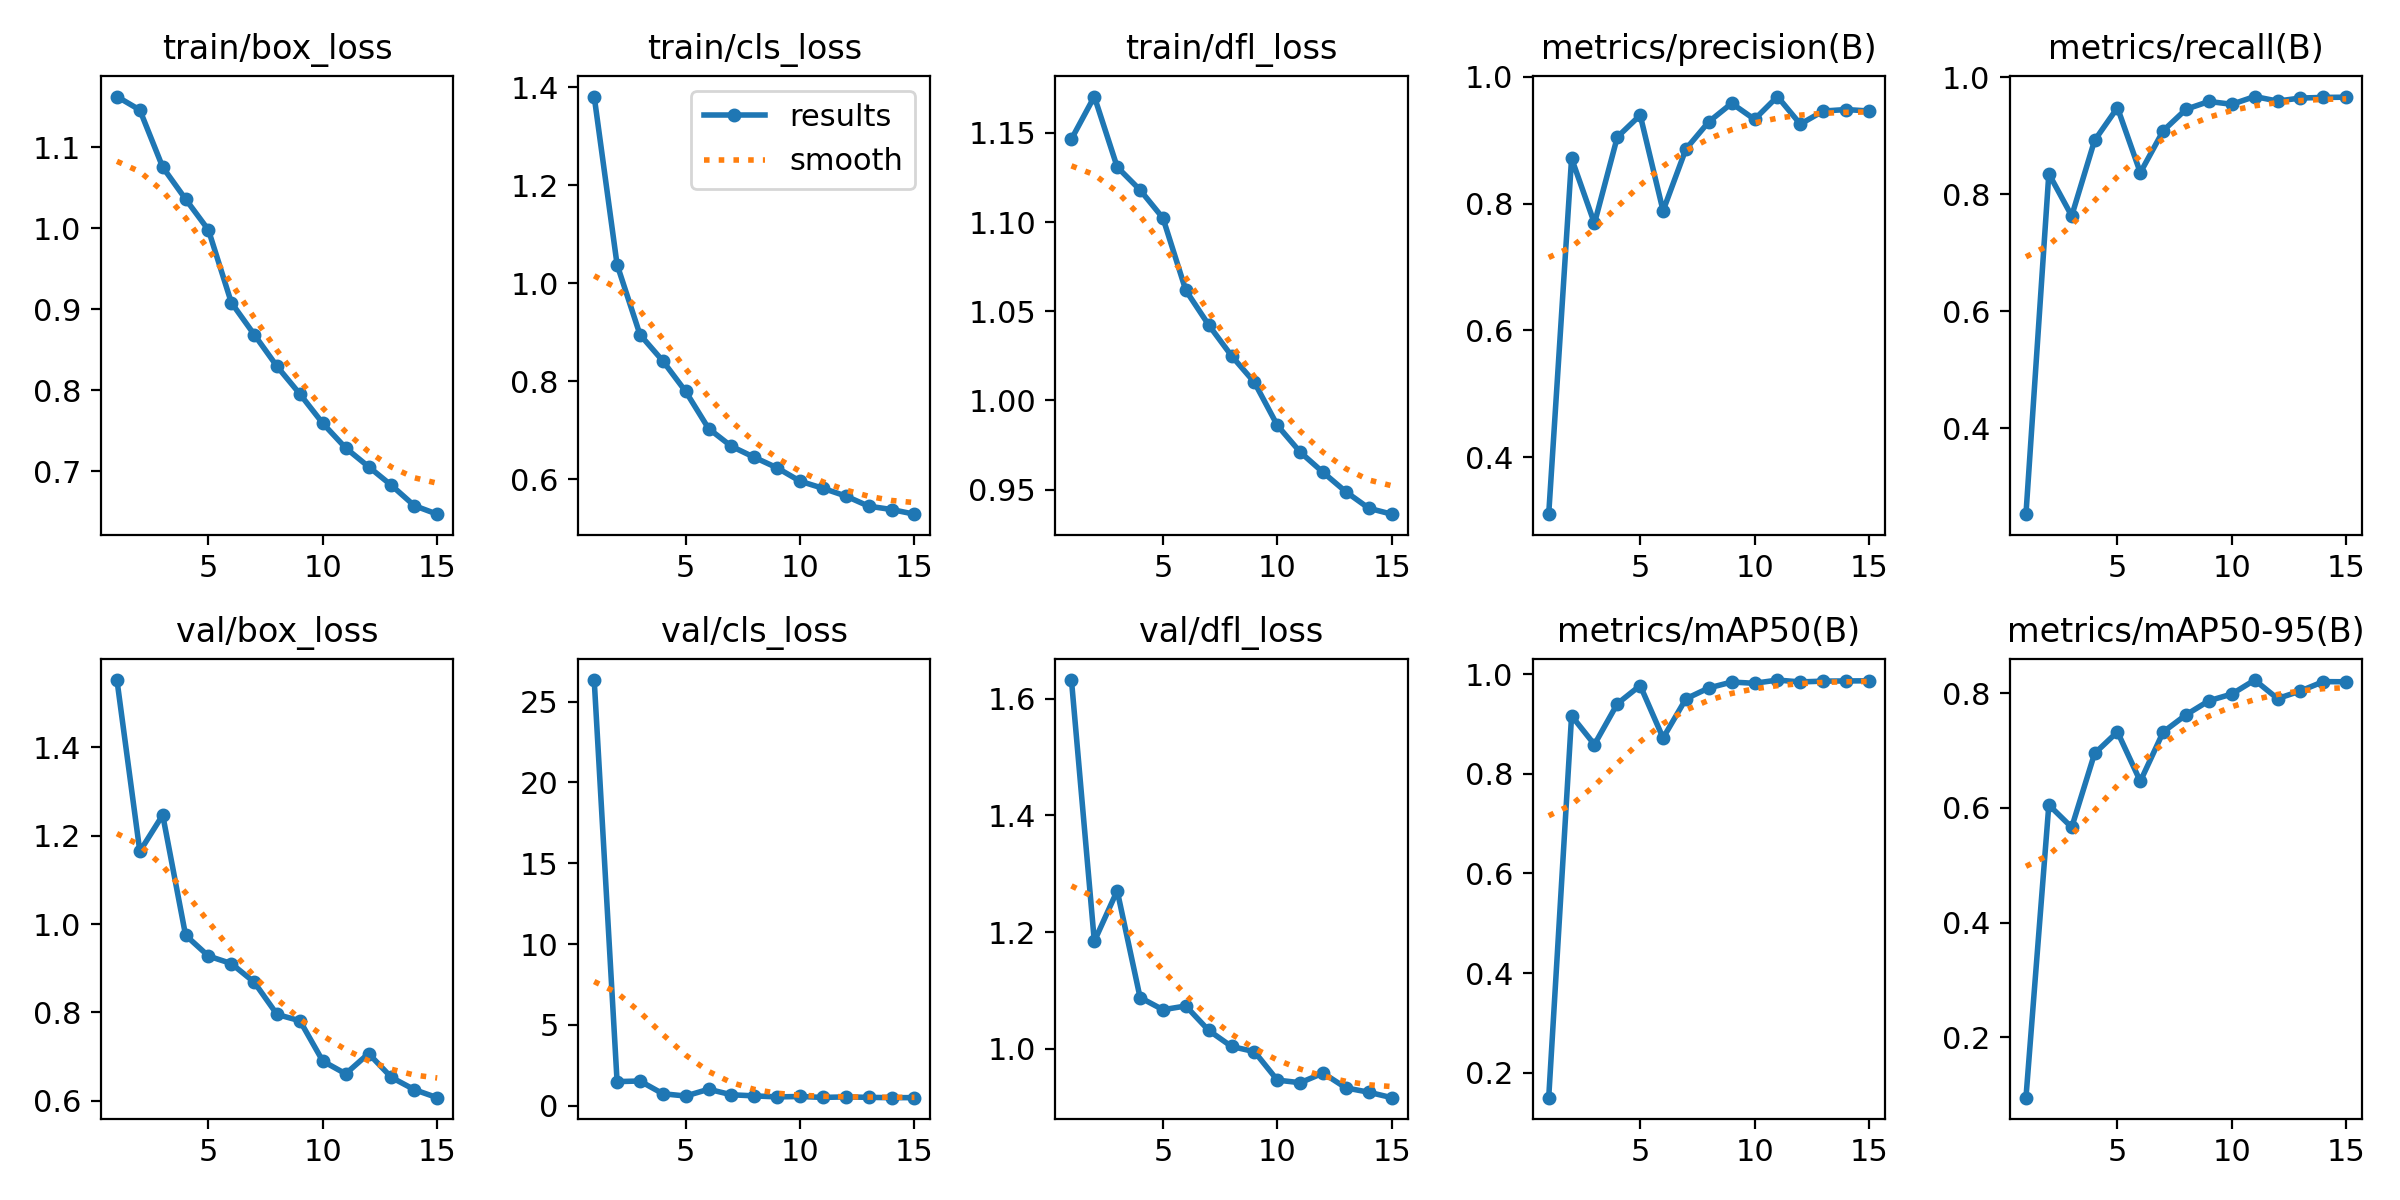


📊 Confusion Matrix:


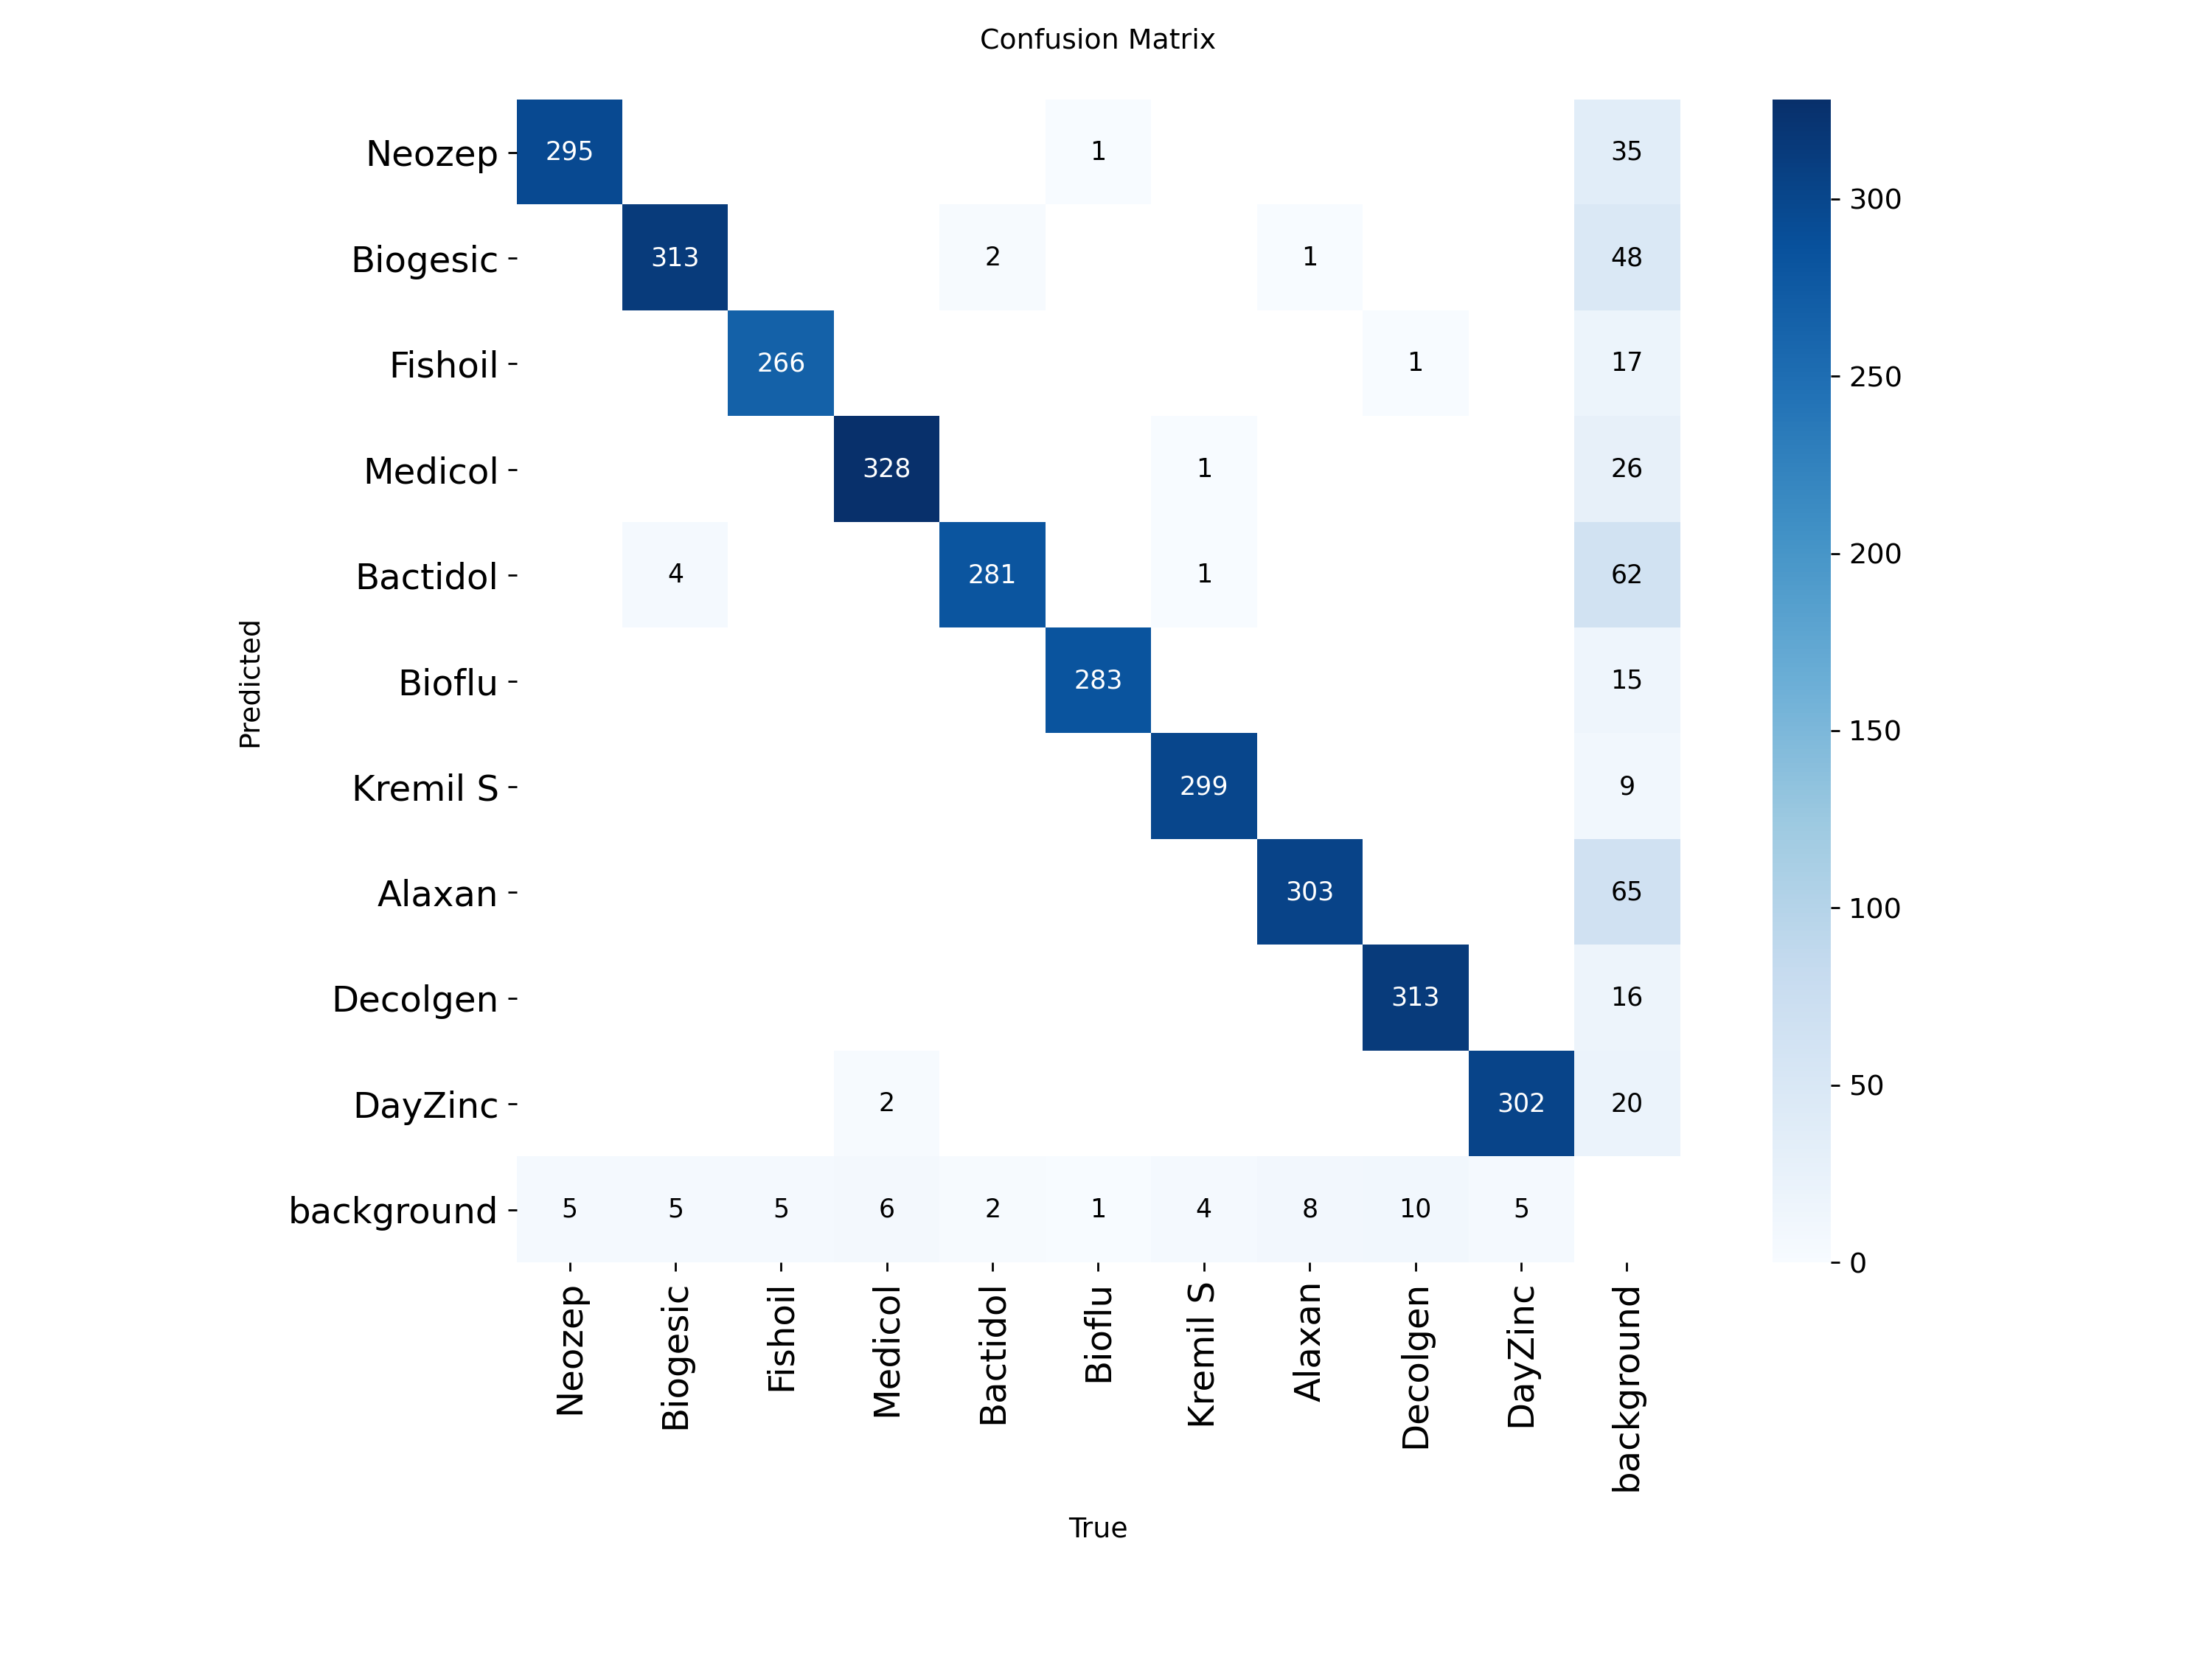

In [8]:
# ============================================================================
# STEP 10: EVALUATE MODEL
# ============================================================================

print("\n" + "=" * 80)
print("STEP 10: Evaluating Model Performance")
print("=" * 80)

# Load best model from Google Drive
best_model = YOLO(BEST_WEIGHTS_PATH)

# Validate on test set
print("\n📊 Validating on test set...")
metrics = best_model.val(data='data.yaml', split='test', imgsz=640)

print("\n📈 Model Performance Metrics:")
print(f"   mAP50: {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")
print(f"   Precision: {metrics.box.mp:.4f}")
print(f"   Recall: {metrics.box.mr:.4f}")

# Display training results
results_img_path = f'{DRIVE_RESULTS}/pill_training/results.png'
if os.path.exists(results_img_path):
    print("\n📊 Displaying training results...")
    results_img = IPImage(filename=results_img_path)
    display(results_img)

# Display confusion matrix
confusion_path = f'{DRIVE_RESULTS}/pill_training/confusion_matrix.png'
if os.path.exists(confusion_path):
    print("\n📊 Confusion Matrix:")
    confusion_matrix = IPImage(filename=confusion_path)
    display(confusion_matrix)



STEP 11: Testing on Sample Images

🔍 Running inference on test images...

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1500 /content/dataset/images/test/00000000.jpg: 640x640 1 Decolgen, 30.8ms
image 2/1500 /content/dataset/images/test/00000010.jpg: 640x640 1 Fishoil, 29.0ms
image 3/1500 /content/dataset/images/test/00000017.jpg: 640x640 1 Fishoil, 1 Bioflu, 1 DayZinc, 36.6ms
image 4/1500 /content/dataset/images/test/00000019.jpg: 640x640 1 Neozep, 1 Alaxan, 15.6ms
image 5/1500 /content/dat

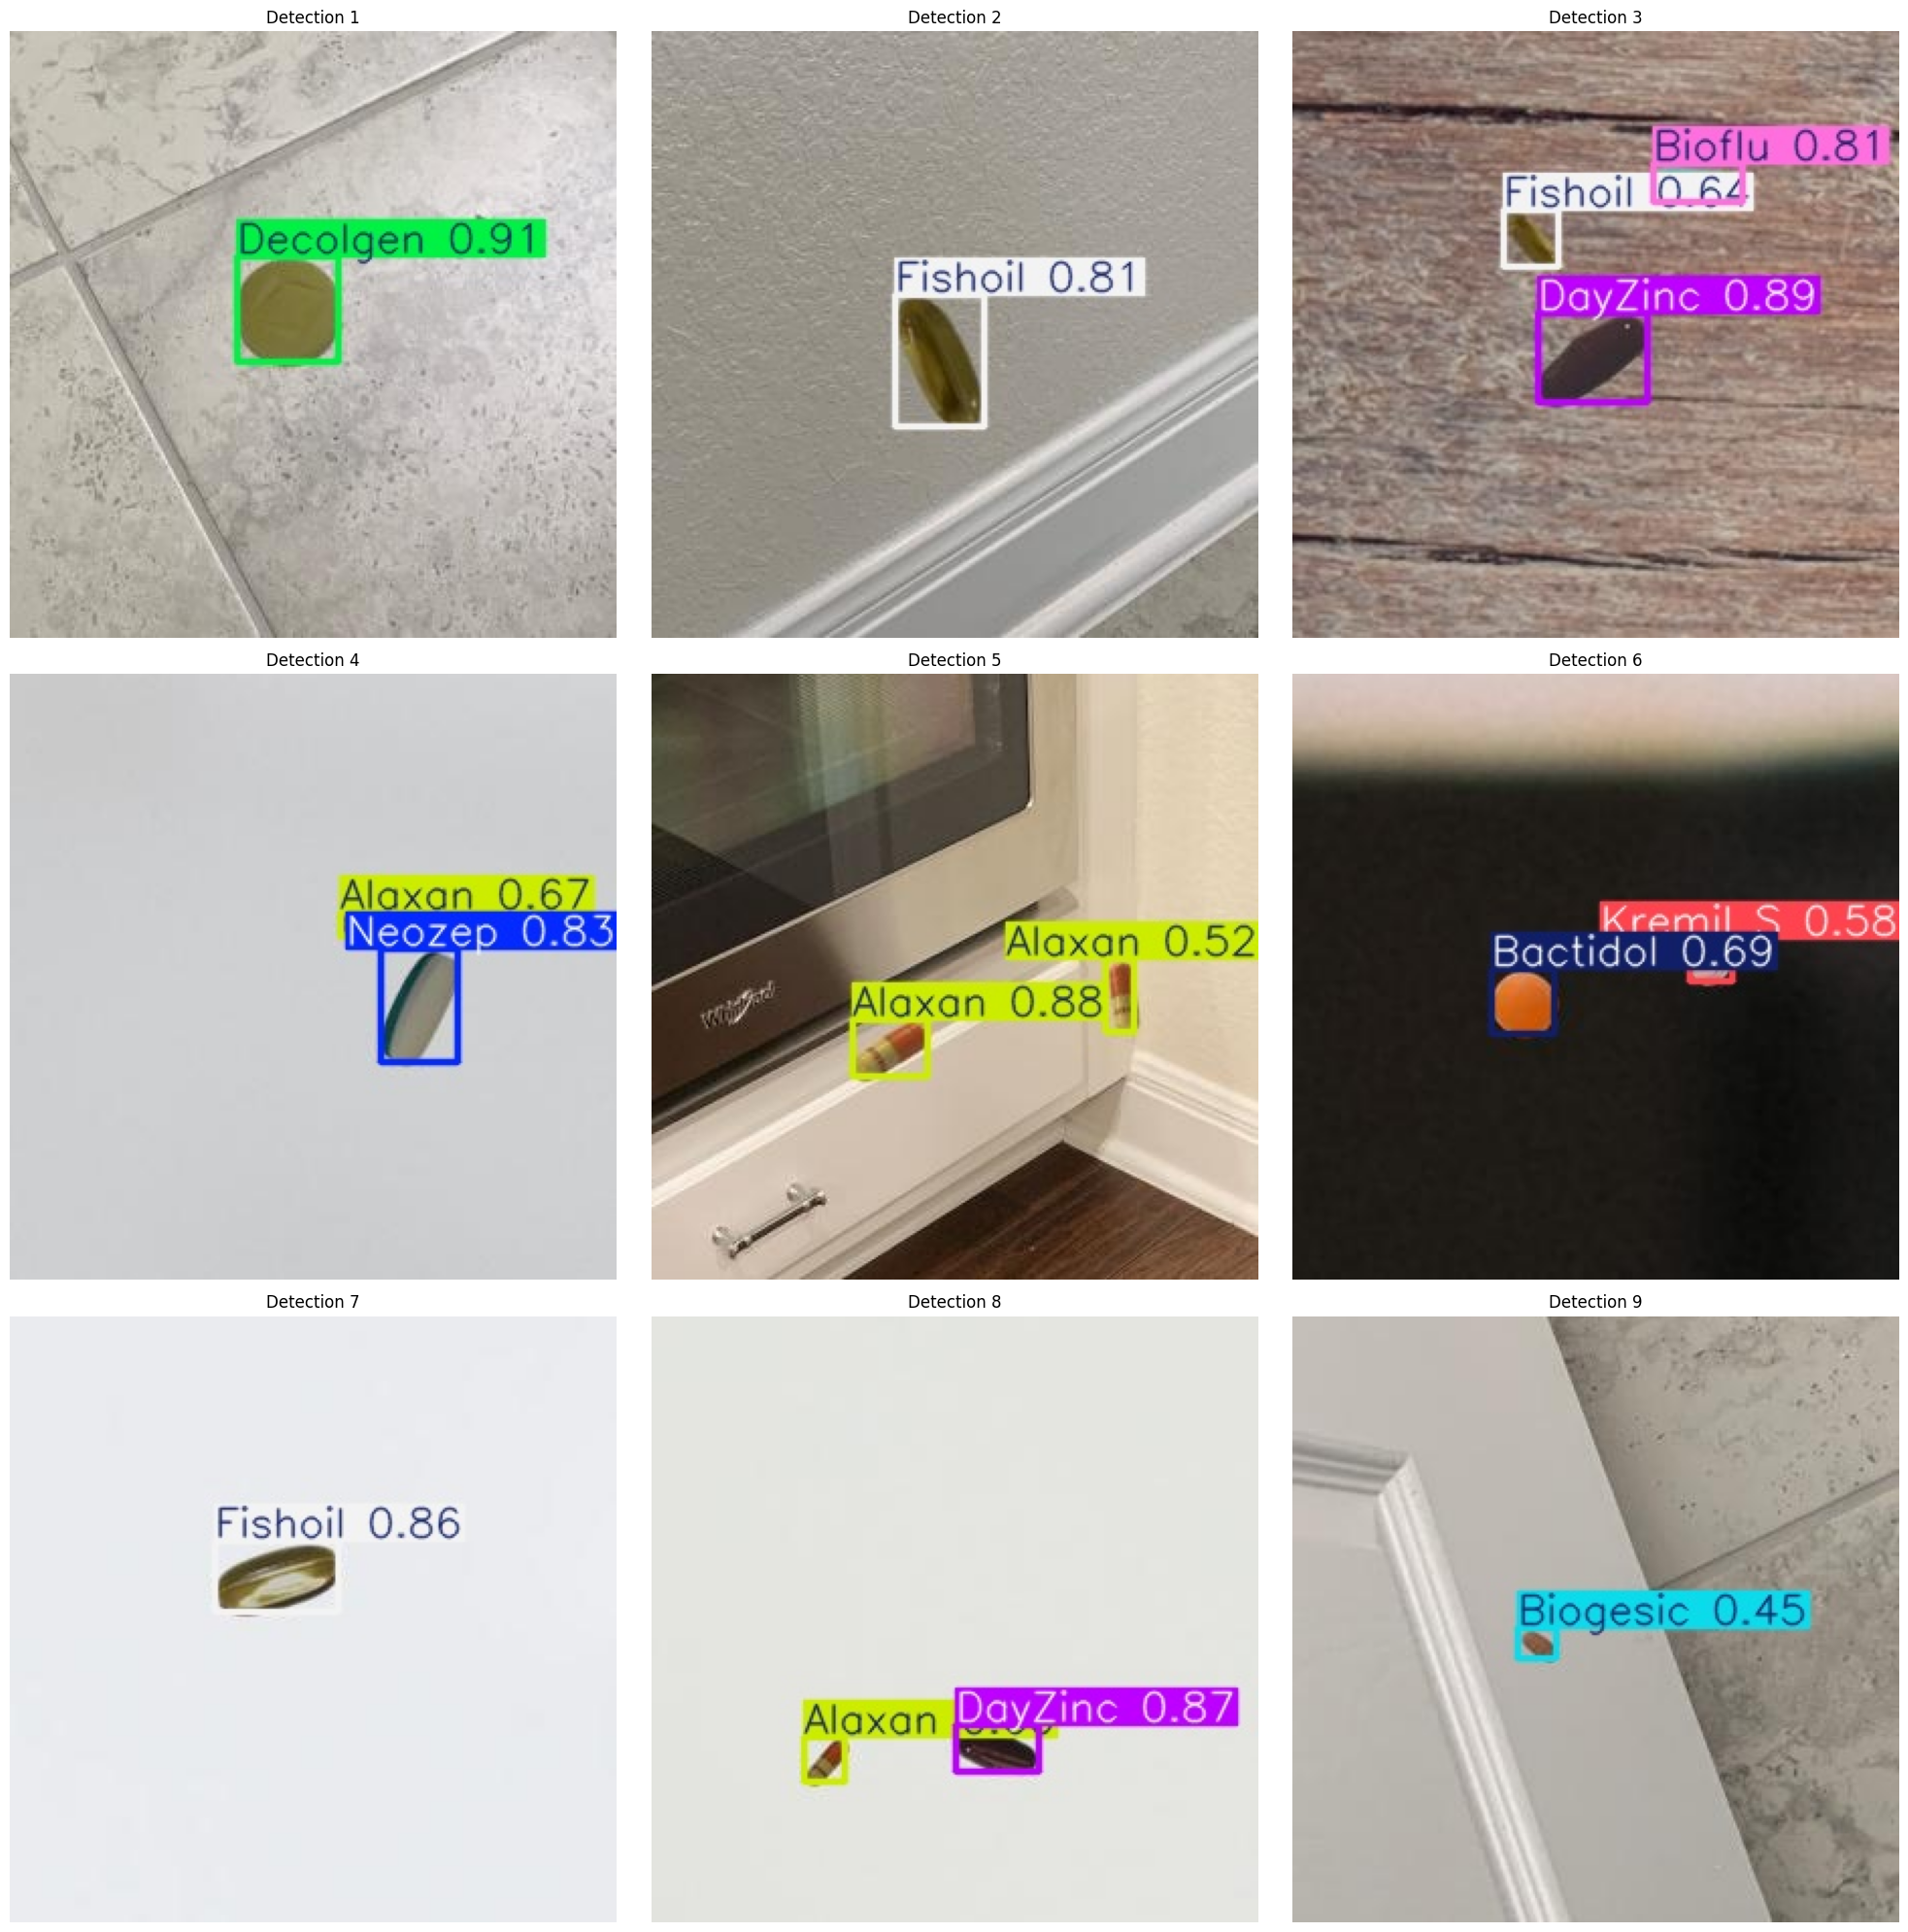


🔍 Testing on single image...

image 1/1 /content/test_image.JPG: 448x640 1 Neozep, 1 Biogesic, 1 Medicol, 1 Bactidol, 1 Bioflu, 1 Kremil S, 1 Alaxan, 1 Decolgen, 1 DayZinc, 54.9ms
Speed: 3.2ms preprocess, 54.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/drive/MyDrive/pill_detection_project/results/single_image_test


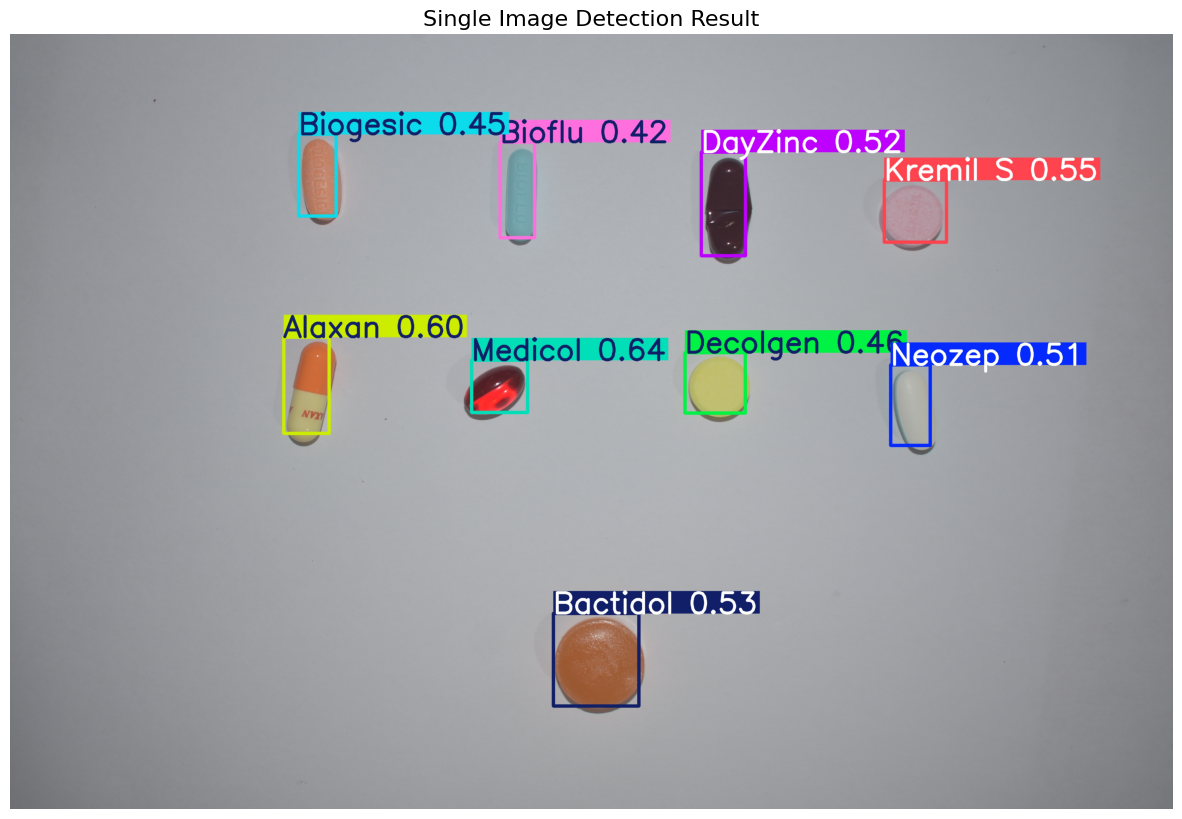

In [9]:
# ============================================================================
# STEP 11: TEST ON IMAGES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 11: Testing on Sample Images")
print("=" * 80)

# Predict on test images
print("\n🔍 Running inference on test images...")
results = best_model.predict(
    source='dataset/images/test',
    conf=0.25,
    iou=0.45,
    imgsz=640,
    save=True,
    project=f'{DRIVE_RESULTS}',
    name='test_images_results',
    exist_ok=True
)

# Display random test results
print("\n🖼️  Sample Detection Results:")
detection_dir = f'{DRIVE_RESULTS}/test_images_results'
detection_images = [os.path.join(detection_dir, x) for x in os.listdir(detection_dir) if x.endswith(('.jpg', '.png'))]

if len(detection_images) > 0:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(detection_images) and i < 9:
            img = Image.open(detection_images[i])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Detection {i+1}', fontsize=12)

    plt.tight_layout()
    plt.show()

# Test on single test image
if os.path.exists('./test_image.JPG'):
    print("\n🔍 Testing on single image...")
    single_test_results = best_model.predict(
        source='./test_image.JPG',
        conf=0.25,
        iou=0.45,
        imgsz=640,
        save=True,
        project=f'{DRIVE_RESULTS}',
        name='single_image_test',
        exist_ok=True
    )

    # Display single test result
    single_test_dir = f'{DRIVE_RESULTS}/single_image_test'
    single_test_images = [os.path.join(single_test_dir, x) for x in os.listdir(single_test_dir) if x.endswith(('.jpg', '.JPG', '.png'))]

    if len(single_test_images) > 0:
        plt.figure(figsize=(15, 15))
        img = Image.open(single_test_images[0])
        plt.imshow(img)
        plt.axis('off')
        plt.title('Single Image Detection Result', fontsize=16)
        plt.show()


In [16]:
# ============================================================================
# STEP 12: TEST ON VIDEO
# ============================================================================

print("\n" + "=" * 80)
print("STEP 12: Testing on Video")
print("=" * 80)

# Upload test video
print("\n📹 Upload your test video (e.g., test_video.mp4):")
uploaded_video = files.upload()

# Get video filename
video_filename = list(uploaded_video.keys())[0]
print(f"\n✅ Video uploaded: {video_filename}")

# Run inference on video
print("\n🎬 Running inference on video...")
print("   This may take several minutes depending on video length...")

video_results = best_model.predict(
    source='pills.mp4',
    conf=0.25,
    iou=0.45,
    imgsz=640,
    save=True,
    project='/content/runs/detect',  # Simpan lokal dulu biar pasti
    name='video_results_fixed',
    exist_ok=True,
    stream=False,
    verbose=True,
    save_frames=True
)

print("\n✅ Video processing completed!")

# Display video info and download
video_results_folder = '/content/runs/detect/video_results_fixed'  # Sesuaikan kalau nama foldernya beda

# Cek apakah folder ada
import os
if os.path.exists(video_results_folder):
    print(f"📁 Hasil ditemukan di: {video_results_folder}")

    # Tampilkan 9 frame contoh langsung di notebook
    from IPython.display import Image, display
    import random

    images = [os.path.join(video_results_folder, f) for f in os.listdir(video_results_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()  # Urutkan biar sesuai urutan frame
    sample_images = images[::len(images)//9] if len(images) > 9 else images  # Ambil 9 sample merata

    print("\n🖼️ Sample hasil deteksi (dengan bounding box dan label):")
    for img_path in sample_images[:9]:
        display(Image(filename=img_path, width=600))

    # Zip semua frame dan download
    print("\n⬇️ Sedang menyiapkan download semua frame hasil deteksi...")
    import shutil
    zip_path = '/content/pills_detection_results_frames.zip'
    shutil.make_archive('/content/pills_detection_results_frames', 'zip', video_results_folder)

    from google.colab import files
    files.download(zip_path)

    # Opsional: Copy ke Google Drive biar permanen
    drive_dest = f'{DRIVE_RESULTS}/video_results_fixed_frames'
    os.makedirs(drive_dest, exist_ok=True)
    shutil.copytree(video_results_folder, drive_dest, dirs_exist_ok=True)
    print(f"✅ Semua frame juga disimpan ke Google Drive: {drive_dest}")

else:
    print("❌ Folder hasil tidak ditemukan. Coba cek nama folder:")
    !ls -la /content/runs/detect/


STEP 12: Testing on Video

📹 Upload your test video (e.g., test_video.mp4):


Saving pills.mp4 to pills (3).mp4

✅ Video uploaded: pills (3).mp4

🎬 Running inference on video...
   This may take several minutes depending on video length...

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/165) /content/pills.mp4: 640x384 (no detections), 10.8ms
video 1/1 (frame 2/165) /content/pills.mp4: 640x384 (no detections), 10.7ms
video 1/1 (frame 3/165) /content/pills.mp4: 640x384 (no detections), 10.6ms
video 1/1 (frame 4/165) /content/pills.mp4: 640x384 (no detections),

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Semua frame juga disimpan ke Google Drive: /content/drive/MyDrive/pill_detection_project/results/video_results_fixed_frames
